## Run MCMC inference using GP model

In [70]:
import random
import time

import tikzplotlib
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp
import numpyro.distributions as npdist
import numpyro
from numpyro.infer import Predictive, init_to_median, MCMC, NUTS
import pickle

import jax.config as config
config.update("jax_enable_x64", True)

from priorCVAE.priors import SquaredExponential, Matern12, Matern52
from experiments.zimbabwe_utility import read_data

numpyro.set_host_device_count(4)

import yaml
import flax.linen as nn
from priorCVAE.models import MLPDecoder
from priorCVAE.utility import load_model_params

from os import listdir

In [71]:
data_path = "../../zimbabwe/data/zwe2016phia.geojson"
num_warmup = 4000
#num_samples = 20000
num_samples = 30000

num_chains = 2
kernel_gp = Matern52()

## Load Data

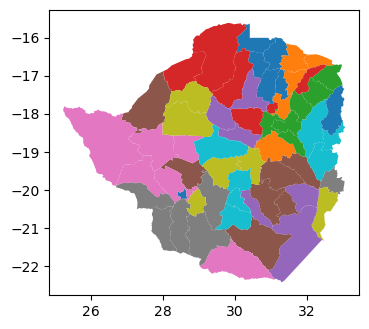

In [72]:
data = gpd.read_file(data_path)

fig, ax = plt.subplots(1, 1, figsize=(4,4))
data.plot(column='area_id', ax=ax, legend=False)

plt.show()

In [73]:
x, data_centroid = read_data(data_path, normalize=True)

/Users/es/Dropbox/00 Oxford/96_cvae_jax_port/PriorCVAE_JAX/experiments/zimbabwe_utility.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  data_frame["centroid"] = data_frame["geometry"].centroid
/Users/es/Dropbox/00 Oxford/96_cvae_jax_port/PriorCVAE_JAX/experiments/zimbabwe_utility.py:17: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  temp_centroids = data_frame["geometry"].centroid


(-0.05888487450251877,
 1.103517848423862,
 -0.058928571428571455,
 1.0589285714285714)

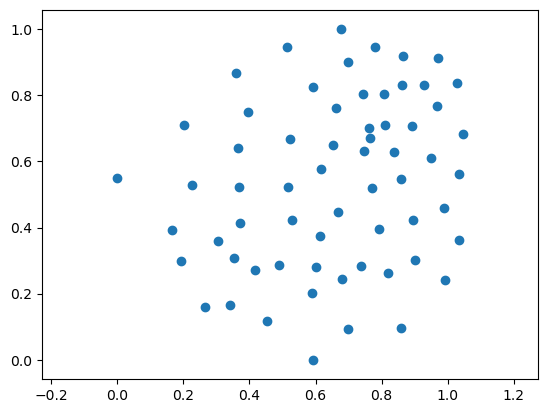

In [74]:
plt.scatter(x[:, 1], x[:, 0])
plt.axis("equal")

In [75]:
## Adding estimate data
data_centroid["estimate"] = data["estimate"]

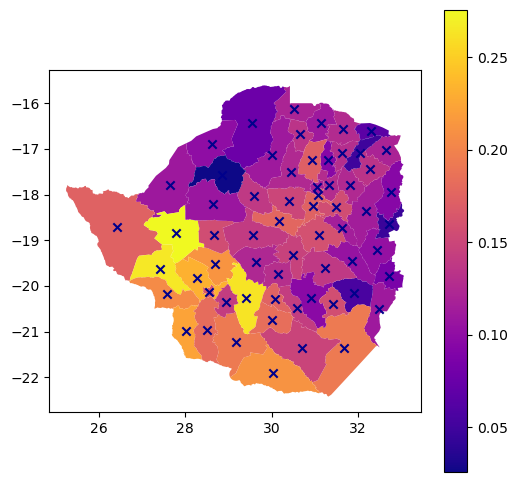

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(6,6))
data_centroid.plot(column='estimate', ax=ax, legend=True, cmap='plasma')
data_centroid["centroid"].plot(ax=ax, color="DarkBlue", marker="x")
plt.show()

In [77]:
def model_gp(x, n_obs=None, kernel=kernel_gp, lengthscale=None, y=None):

    #if lengthscale == None: 
        #lengthscale = numpyro.sample("lengthscale", npdist.Uniform(0, 1.0)) 
    
    lengthscale = numpyro.sample("lengthscale", npdist.Gamma(0.4, 2.0)) 
        
    kernel.lengthscale = lengthscale
    k = kernel(x, x)
    
    kernel_var = numpyro.sample("variance", npdist.Gamma(1.5, 1.5)) 
    N = x.shape[0]
    re_std = numpyro.sample('re_std', npdist.MultivariateNormal(loc=jnp.zeros(N), covariance_matrix=k))
    re = numpyro.deterministic('re', kernel_var * re_std)
    
    # calculated here as it is required later for plotting purposes
    theta = numpyro.deterministic("theta", jax.nn.sigmoid(re))
    
    # Logits transformation happens inside the numpyro distribution.
    numpyro.sample("obs", npdist.BinomialLogits(total_count = n_obs, logits=re), obs=y)

## Observations

In [78]:
data['y'] = round(data['y']).astype(int)
data['n_obs'] = round(data['n_obs']).astype(int)

## GP Prior

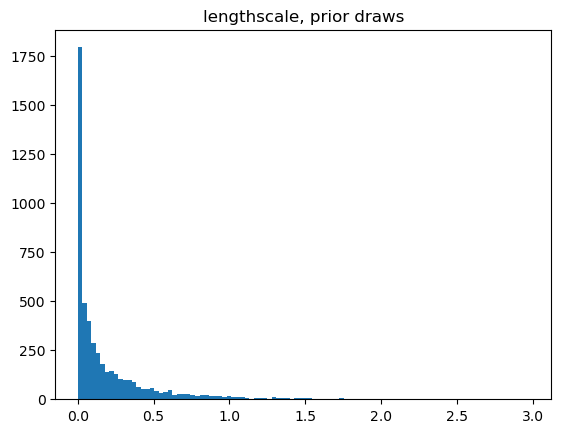

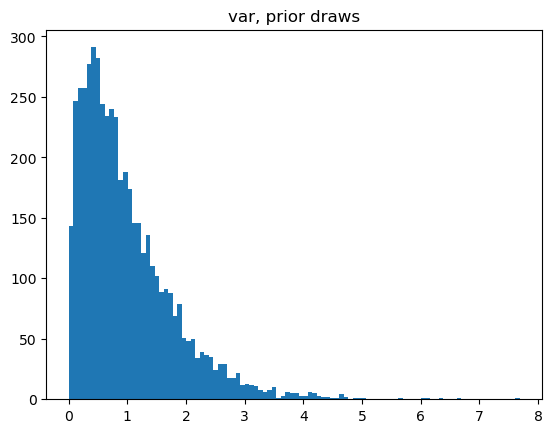

In [79]:
rng_key, rng_key_ = jax.random.split(jax.random.PRNGKey(random.randint(0, 9999)))
gp_predictive = Predictive(model_gp, num_samples=5000)
gp_preds = gp_predictive(rng_key_, x=x, n_obs = jnp.array(data.n_obs))

ls_prior_draws = gp_preds['lengthscale']
plt.hist(ls_prior_draws, bins=100)
plt.title('lengthscale, prior draws')
plt.show()

kernel_var_prior = gp_preds['variance']
plt.hist(kernel_var_prior, bins=100)
plt.title('var, prior draws')
plt.show()

## MCMC Inference using GP Prior

In [50]:
rng_key, rng_key_predict = jax.random.split(jax.random.PRNGKey(random.randint(0, 999999)))

# inference
start = time.time()
mcmc_gp_model = NUTS(model_gp)
mcmc_gp = MCMC(mcmc_gp_model, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)
mcmc_gp.run(rng_key, x=x, n_obs = jnp.array(data.n_obs), y = jnp.array(data.y), kernel=Matern52())
t_elapsed = time.time() - start

  0%|          | 0/34000 [00:00<?, ?it/s]

  0%|          | 0/34000 [00:00<?, ?it/s]

In [22]:
#fname = 'mcmc_fits/zimbabwe_gp_mcmc_Matern52_Gamma.pkl'

#with open(fname, 'wb') as f:
#    pickle.dump(mcmc_gp, f)

In [51]:
mcmc_gp.print_summary(exclude_deterministic=True)
mcmc_gp_samples = mcmc_gp.get_samples()


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      0.65      0.13      0.65      0.42      0.84    388.88      1.03
    re_std[0]     -1.13      0.27     -1.11     -1.54     -0.65    352.56      1.01
    re_std[1]     -1.34      0.33     -1.33     -1.84     -0.79    360.28      1.01
    re_std[2]     -1.35      0.33     -1.34     -1.84     -0.78    358.05      1.01
    re_std[3]     -1.55      0.38     -1.52     -2.11     -0.90    363.92      1.01
    re_std[4]     -1.69      0.41     -1.67     -2.31     -1.00    366.28      1.01
    re_std[5]     -1.51      0.37     -1.49     -2.07     -0.88    371.08      1.01
    re_std[6]     -1.54      0.38     -1.52     -2.12     -0.92    369.11      1.01
    re_std[7]     -1.66      0.40     -1.64     -2.27     -0.99    363.29      1.01
    re_std[8]     -1.68      0.41     -1.66     -2.30     -1.00    376.63      1.01
    re_std[9]     -1.64      0.40     -1.62     -2.27     -0.99    389.31  

In [52]:
print("\nMCMC elapsed time:", round(t_elapsed), "s")

ss = numpyro.diagnostics.summary(mcmc_gp.get_samples(group_by_chain=True))
r = jnp.mean(ss['re']['n_eff'])
print("Average ESS for all REs : " + str(round(r)))


MCMC elapsed time: 3698 s
Average ESS for all REs : 9709


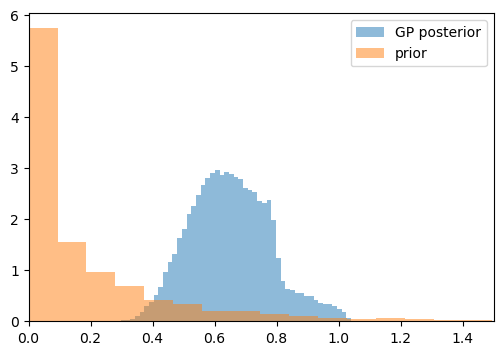

In [53]:
c_samps_gp = mcmc_gp_samples['lengthscale']

fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plt.hist(c_samps_gp, density=True, label = 'GP posterior', bins=50, alpha=0.5)
plt.hist(ls_prior_draws, density=True, label = 'prior', bins=50, alpha=0.5)
# plt.title('lengthscale, prior and posterior')
plt.legend()
plt.xlim([0, 1.5])

#tikzplotlib.save(r"lengthscale.tex",
#                 figurewidth='\\figurewidth', figureheight='\\figureheight',
#                 figure=fig)

plt.show()

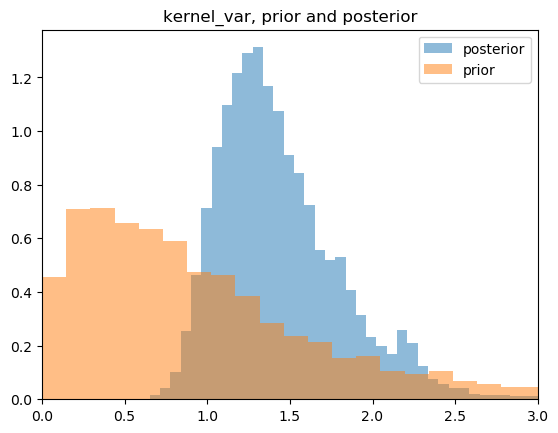

In [54]:
var_samps_gp = mcmc_gp_samples['variance']
plt.hist(var_samps_gp, density=True, label = 'posterior', bins=50, alpha=0.5)
plt.hist(kernel_var_prior, density=True, label = 'prior', bins=50, alpha=0.5)
plt.title('kernel_var, prior and posterior')
plt.legend()
plt.xlim(0,3)

# tikzplotlib.save(r"variance.tex",
#                 figurewidth='\\figurewidth', figureheight='\\figureheight',
#                 figure=fig)

plt.show()

(24.8460406, 33.4588074, -22.7626307, -15.268733300000001)

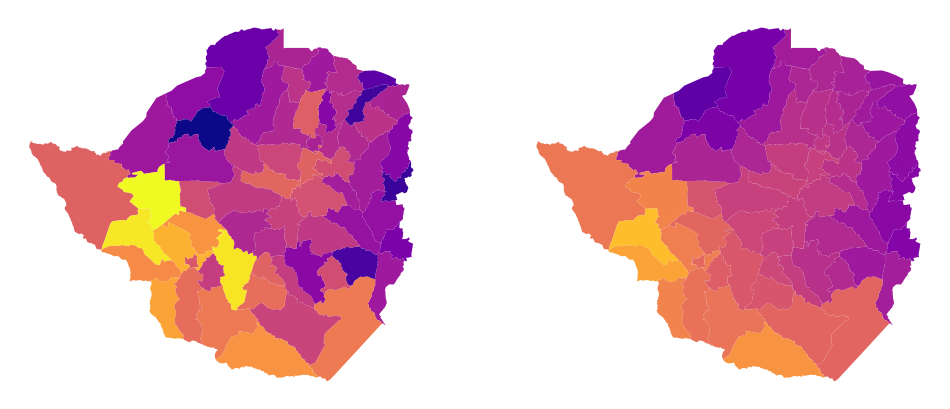

In [55]:
# posterior predictive
posterior_predictive_gp = Predictive(model_gp, mcmc_gp_samples)(jax.random.PRNGKey(random.randint(0, 9999)), 
                                                                         x=x, 
                                                                         n_obs = jnp.array(data.n_obs))


theta_samps_gp = posterior_predictive_gp['theta']
theta_mean_gp = theta_samps_gp.mean(axis=0)
bci_gp_25 = jnp.quantile(theta_samps_gp, 0.25, axis=0)
bci_gp_75 = jnp.quantile(theta_samps_gp, 0.75, axis=0)

data['theta_gp'] = theta_mean_gp

theta_observed = jnp.array(data['estimate'])
theta_estimated_gp = jnp.array(data['theta_gp'])

_max = np.max([theta_observed, theta_estimated_gp])
_min = np.min([theta_observed, theta_estimated_gp])

fig, ax = plt.subplots(1, 2, figsize=(12,6))
data.plot(column="estimate", ax=ax[0], cmap='plasma', vmin=_min, vmax =_max)
data.plot(column="theta_gp", ax=ax[1], cmap='plasma', vmin=_min, vmax =_max)

ax[0].axis("off")
ax[1].axis("off")

In [56]:
#fig, ax = plt.subplots(1, 1, figsize=(5, 5))
#data.plot(column="estimate", ax=ax, cmap='plasma', vmin=_min, vmax =_max)

#plt.axis("off")
#plt.tight_layout()
#plt.savefig("estimate.pdf")
#plt.show()

In [57]:
#fig, ax = plt.subplots(1, 1, figsize=(5, 5))
#data.plot(column="theta_gp", ax=ax, cmap='plasma', vmin=_min, vmax =_max)

#plt.axis("off")
#plt.tight_layout()
#plt.savefig("gp_inference.pdf")
#plt.show()

## Define model - PriorCVAE

In [80]:
outputs_path = "../../outputs/"

from os import listdir

print(listdir(outputs_path))

print(len(listdir(outputs_path)))

['c9olhh5v', '6dv9hm9r', 'wuhdr96j', 'b020qrpe', 'vmp2r78b', 'yzgfmgh6', 'ibxrpwlp', 'fvk8l9r1']
8


In [81]:
#data_path = "../../zimbabwe/data/zwe2016phia.geojson"

dirs = listdir(outputs_path) 
#dirs = ["6dv9hm9r", "c9olhh5v", "fvk8l9r1", "vmp2r78b", "yzgfmgh6"]
dir_paths = ["../../outputs/" + dirs[i] for i in range(len(dirs))]

In [82]:
dir_paths

['../../outputs/c9olhh5v',
 '../../outputs/6dv9hm9r',
 '../../outputs/wuhdr96j',
 '../../outputs/b020qrpe',
 '../../outputs/vmp2r78b',
 '../../outputs/yzgfmgh6',
 '../../outputs/ibxrpwlp',
 '../../outputs/fvk8l9r1']

In [83]:
#output_dir = "../../outputs/6dv9hm9r"
#data_path = "../../zimbabwe/data/zwe2016phia.geojson"
#n_samples = 5000

In [84]:
def model_cvae(trained_decoder_params, latent_dim, n_obs=None, lengthscale=None, y=None):
    
    lengthscale = numpyro.sample("lengthscale", npdist.Gamma(0.4, 2.0)) 

    c = jnp.array([lengthscale])

    kernel_var = numpyro.sample("variance", npdist.Gamma(1.5, 1.5)) 
    
    z = numpyro.sample("z", npdist.Normal(jnp.zeros(latent_dim), jnp.ones(latent_dim)))
    z = jnp.concatenate([z, c]) 
    f = numpyro.deterministic('f', decoder.apply({'params': trained_decoder_params}, z))
     
    re = numpyro.deterministic('re', kernel_var * f)
    
    theta = numpyro.deterministic("theta", jax.nn.sigmoid(re))
    
    numpyro.sample("obs", npdist.BinomialLogits(total_count = n_obs, logits=re), obs=y)

In [85]:
import os

c_samps_cvae_lst = []

for output_dir in dir_paths:
    print(output_dir)
    cfg_path = os.path.join(output_dir, "files", "config.yaml")
    with open(cfg_path, 'r') as file:
        cfg_data = yaml.safe_load(file)

    conditional = cfg_data["conditional"]['value']
    latent_dim = cfg_data["latent_dim"]['value']
    normalize = cfg_data["normalize"]['value']
    dec_activation_fn = cfg_data["dec_activation"]['value']["_target_"]
    dec_activation_fn = getattr(nn, dec_activation_fn.split(".")[-1])

    trained_decoder_params = load_model_params(os.path.join(output_dir, "model"))["decoder"]
    output_dim = trained_decoder_params["dec_out"]["bias"].shape[0]
    hidden_dim = trained_decoder_params["dec_hidden_0"]["bias"].shape[0]
    decoder = MLPDecoder(hidden_dim=hidden_dim, out_dim=output_dim, activations=dec_activation_fn)

    rng_key, rng_key_predict = jax.random.split(jax.random.PRNGKey(random.randint(0, 999999)))

    # inference
    start = time.time()
    kernel = NUTS(model_cvae)
    mcmc_cvae = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)
    mcmc_cvae.run(rng_key, trained_decoder_params, latent_dim=latent_dim, n_obs = jnp.array(data.n_obs), y = jnp.array(data.y))
    t_elapsed = time.time() - start
    print(t_elapsed)

    mcmc_cvae.print_summary(exclude_deterministic=True)

    mcmc_cvae_samples = mcmc_cvae.get_samples()

    c_samps_cvae = mcmc_cvae_samples['lengthscale']

    c_samps_cvae_lst.append(c_samps_cvae)

../../outputs/c9olhh5v


  0%|          | 0/34000 [00:00<?, ?it/s]

  0%|          | 0/34000 [00:00<?, ?it/s]

36.90954613685608

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      0.56      0.11      0.56      0.39      0.73   3870.64      1.00
     variance      1.82      0.65      1.67      0.90      2.81   2263.50      1.00
         z[0]      0.01      1.00      0.01     -1.57      1.70  35850.47      1.00
         z[1]      0.06      1.00      0.05     -1.62      1.67  40605.52      1.00
         z[2]     -0.02      0.99     -0.02     -1.61      1.66  41737.85      1.00
         z[3]     -0.03      1.00     -0.03     -1.66      1.66  33062.44      1.00
         z[4]      0.05      1.00      0.06     -1.58      1.71  12613.68      1.00
         z[5]      0.26      0.92      0.26     -1.27      1.75  37956.45      1.00
         z[6]      0.02      1.00      0.01     -1.59      1.69  48139.88      1.00
         z[7]     -0.81      0.86     -0.82     -2.26      0.56  21971.63      1.00
         z[8]     -0.58      0.55     -0.46     -1.51    

  0%|          | 0/34000 [00:00<?, ?it/s]

  0%|          | 0/34000 [00:00<?, ?it/s]

26.047613859176636

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      0.45      0.10      0.44      0.34      0.52   1240.91      1.00
     variance      1.28      0.35      1.21      0.79      1.76   3677.02      1.00
         z[0]      0.01      1.00      0.01     -1.65      1.65  96212.75      1.00
         z[1]     -0.65      0.34     -0.59     -1.15     -0.14   5131.07      1.00
         z[2]     -0.24      0.93     -0.25     -1.75      1.32  54582.11      1.00
         z[3]      0.01      0.15      0.00     -0.22      0.26  16818.06      1.00
         z[4]      0.01      1.01      0.02     -1.65      1.64  87820.25      1.00
         z[5]     -0.00      1.00      0.00     -1.65      1.63 102120.88      1.00
         z[6]     -0.01      1.00     -0.01     -1.63      1.66  88690.30      1.00
         z[7]     -0.01      1.00     -0.01     -1.65      1.63  96744.94      1.00
         z[8]      0.74      0.89      0.76     -0.70   

  0%|          | 0/34000 [00:00<?, ?it/s]

  0%|          | 0/34000 [00:00<?, ?it/s]

43.041956186294556

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      1.09      0.17      1.06      0.83      1.34  13768.07      1.00
     variance      2.38      0.95      2.10      1.13      3.89  10622.58      1.00
         z[0]      0.68      0.97      0.68     -0.90      2.27  76537.51      1.00
         z[1]      0.36      1.00      0.36     -1.28      2.01  85251.49      1.00
         z[2]     -0.31      1.01     -0.31     -1.99      1.35  69867.56      1.00
         z[3]      1.91      0.71      1.93      0.75      3.09  52877.47      1.00
         z[4]     -0.28      1.00     -0.28     -1.90      1.39  82322.76      1.00
         z[5]     -0.01      1.00     -0.00     -1.65      1.64  83081.40      1.00
         z[6]      0.19      1.00      0.19     -1.44      1.84  75604.74      1.00
         z[7]     -0.13      1.00     -0.13     -1.74      1.56  82959.11      1.00
         z[8]      0.54      1.01      0.54     -1.08   

  0%|          | 0/34000 [00:00<?, ?it/s]

  0%|          | 0/34000 [00:00<?, ?it/s]

92.34793496131897

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      0.52      0.21      0.47      0.32      0.62     23.08      1.06
     variance      3.02      1.54      2.70      1.05      5.23    740.84      1.01
         z[0]     -0.00      1.00     -0.00     -1.63      1.66  48582.78      1.00
         z[1]      0.28      0.86      0.27     -1.12      1.70   9291.23      1.00
         z[2]     -0.14      0.21     -0.14     -0.48      0.17   2794.66      1.00
         z[3]      0.03      0.99      0.03     -1.63      1.63  53627.56      1.00
         z[4]      1.13      0.62      0.96      0.27      2.02    583.78      1.01
         z[5]     -0.22      1.00     -0.22     -1.84      1.46   2189.70      1.00
         z[6]      0.10      1.00      0.10     -1.57      1.73   7176.78      1.00
         z[7]     -0.08      0.99     -0.08     -1.74      1.53  59580.31      1.00
         z[8]      0.15      1.01      0.15     -1.47    

  0%|          | 0/34000 [00:00<?, ?it/s]

  0%|          | 0/34000 [00:00<?, ?it/s]

28.59282112121582

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      0.59      0.04      0.60      0.52      0.66  21818.34      1.00
     variance      2.07      0.70      1.93      1.05      3.09   6877.94      1.00
         z[0]      0.15      1.00      0.15     -1.46      1.82  81438.03      1.00
         z[1]      2.83      0.55      2.80      1.92      3.72  17015.04      1.00
         z[2]      0.23      0.06      0.23      0.13      0.33  16684.46      1.00
         z[3]      0.12      0.19      0.12     -0.20      0.43  35049.83      1.00
         z[4]      0.26      0.99      0.26     -1.38      1.87  75058.92      1.00
         z[5]     -0.07      1.00     -0.08     -1.67      1.59  75852.76      1.00
         z[6]      0.17      1.00      0.17     -1.47      1.81  74582.76      1.00
         z[7]      0.01      1.00      0.01     -1.65      1.66  65504.86      1.00
         z[8]      0.10      1.00      0.10     -1.55    

  0%|          | 0/34000 [00:00<?, ?it/s]

  0%|          | 0/34000 [00:00<?, ?it/s]

78.26708674430847

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      0.38      0.21      0.35      0.00      0.62   2683.07      1.00
     variance      0.93      0.17      0.90      0.65      1.18   7454.87      1.00
         z[0]      0.78      0.37      0.77      0.19      1.40  36799.32      1.00
         z[1]      0.36      0.28      0.35     -0.09      0.82  35357.87      1.00
         z[2]      0.14      0.35      0.13     -0.42      0.73  27076.04      1.00
         z[3]      1.17      0.27      1.15      0.72      1.61  10682.26      1.00
         z[4]     -0.38      0.87     -0.47     -1.75      1.10  19541.72      1.00
         z[5]      0.26      0.80      0.25     -1.10      1.59  40959.91      1.00
         z[6]      0.34      0.82      0.33     -1.07      1.66  36018.27      1.00
         z[7]      0.35      0.19      0.34      0.04      0.66  18330.58      1.00
         z[8]     -0.03      0.36     -0.04     -0.62    

  0%|          | 0/34000 [00:00<?, ?it/s]

  0%|          | 0/34000 [00:00<?, ?it/s]

36.58967089653015

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      0.39      0.04      0.39      0.33      0.45  13327.69      1.00
     variance      1.59      0.31      1.56      1.10      2.07  19684.89      1.00
         z[0]     -0.06      0.99     -0.05     -1.67      1.60 112123.14      1.00
         z[1]     -0.03      1.00     -0.03     -1.68      1.61 121012.86      1.00
         z[2]     -1.28      0.27     -1.25     -1.71     -0.84  22140.43      1.00
         z[3]     -0.07      0.99     -0.07     -1.78      1.49 114519.61      1.00
         z[4]      0.08      1.00      0.07     -1.52      1.75 117686.34      1.00
         z[5]     -0.06      1.00     -0.06     -1.68      1.59 110122.51      1.00
         z[6]      0.17      0.99      0.16     -1.49      1.77 119824.78      1.00
         z[7]     -0.08      1.00     -0.08     -1.71      1.61 113244.54      1.00
         z[8]      1.82      0.36      1.78      1.26    

  0%|          | 0/34000 [00:00<?, ?it/s]

  0%|          | 0/34000 [00:00<?, ?it/s]

54.73441004753113

                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      0.41      0.18      0.42      0.00      0.62    795.73      1.00
     variance      1.21      0.48      1.07      0.65      1.90   1549.68      1.00
         z[0]      0.04      1.00      0.05     -1.57      1.73  25080.52      1.00
         z[1]      0.53      0.93      0.61     -1.04      2.03   5505.89      1.00
         z[2]     -0.08      0.85     -0.13     -1.51      1.32  16870.91      1.00
         z[3]     -0.19      0.89     -0.29     -1.55      1.37   7938.65      1.00
         z[4]      1.20      0.42      1.15      0.55      1.83   7028.01      1.00
         z[5]      0.92      0.39      0.86      0.30      1.49   1189.57      1.00
         z[6]     -0.23      0.89     -0.27     -1.71      1.24  16949.72      1.00
         z[7]     -1.25      0.46     -1.21     -1.96     -0.48   1178.41      1.00
         z[8]      0.01      1.00      0.01     -1.64    

(0, 1.0)

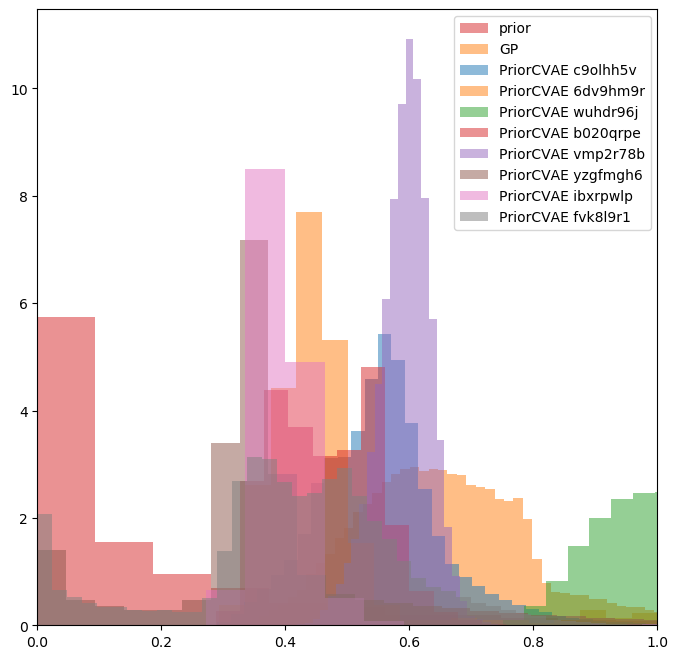

In [64]:
fig, axs = plt.subplots(1, 1, figsize=(8, 8))

plt.hist(ls_prior_draws, density=True, bins=50, alpha=0.5, color="tab:red", label='prior')
plt.hist(c_samps_gp, density=True, bins=50, alpha=0.5, color="tab:orange", label='GP')

for i in range(len(c_samps_cvae_lst)):
    #plt.hist(c_samps_cvae_lst[i], density=True, bins=50, alpha=0.5, color="tab:blue", label='PriorCVAE')
    plt.hist(c_samps_cvae_lst[i], density=True, bins=50, alpha=0.5, label='PriorCVAE ' + dirs[i])

plt.legend()
plt.xlim(0, 1.)

(0, 1.0)

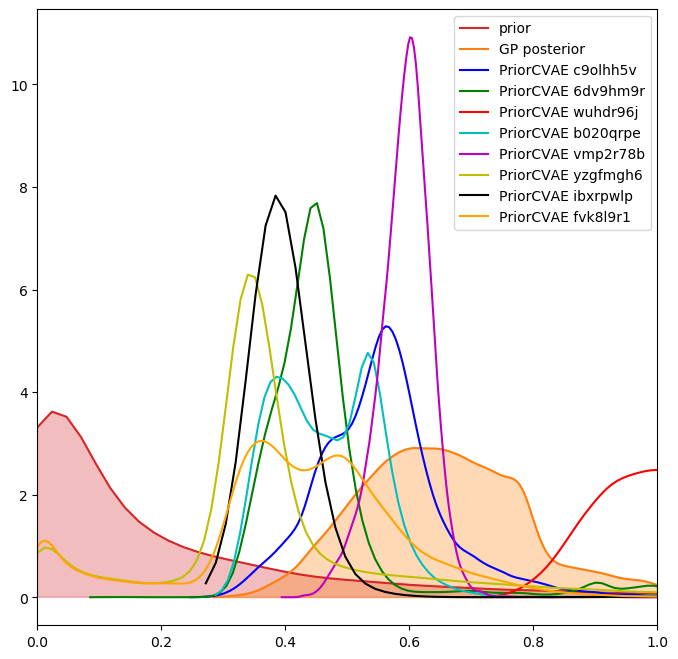

In [66]:
from scipy.stats import gaussian_kde

def make_kde(data):
    density = gaussian_kde(data)
    x_vals = np.linspace(data.min(), data.max(), 200)
    y_vals = density(x_vals)

    return x_vals, y_vals

fig, axs = plt.subplots(1, 1, figsize=(8, 8))

x_vals, y_vals = make_kde(ls_prior_draws)
plt.plot(x_vals, y_vals, 'r', label='prior', color="tab:red")
plt.fill_between(x_vals, 0, y_vals, color="tab:red", alpha=0.3)

x_vals, y_vals = make_kde(c_samps_gp)
plt.plot(x_vals, y_vals, 'r', label='GP posterior', color="tab:orange")
plt.fill_between(x_vals, 0, y_vals, color="tab:orange", alpha=0.3)

colors = ['b', 'g', 'r', 'c', 'm', 'y', 'k', 'orange']

for i in range(len(c_samps_cvae_lst)):
    x_vals, y_vals = make_kde(c_samps_cvae_lst[i])
    #plt.hist(c_samps_cvae_lst[i], density=True, bins=50, alpha=0.5, label='PriorCVAE ' + dirs[i])
    plt.plot(x_vals, y_vals, 'r', label='PriorCVAE ' + dirs[i], color=colors[i])

plt.legend()
plt.xlim(0, 1.)

## Specific model

### Model 1

In [87]:
#dir_paths

# '../../outputs/wuhdr96j'
# '../../outputs/vmp2r78b'

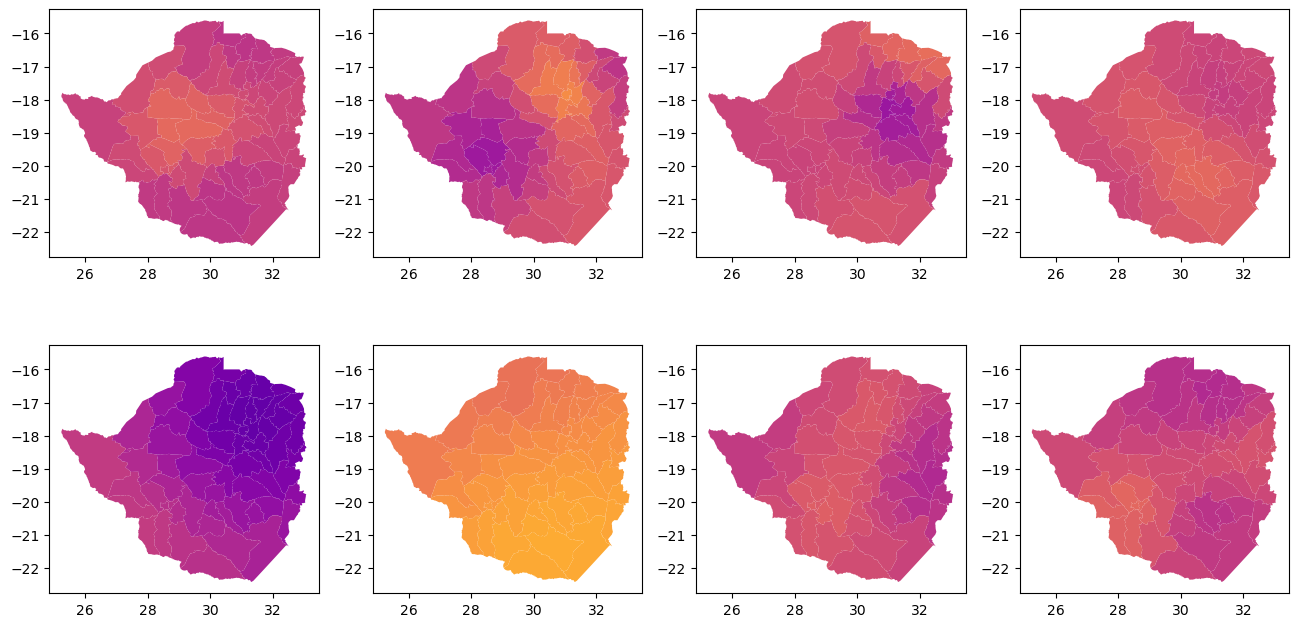

In [92]:
output_dir = '../../outputs/wuhdr96j'

trained_decoder_params = load_model_params(os.path.join(output_dir, "model"))["decoder"]
output_dim = trained_decoder_params["dec_out"]["bias"].shape[0]
hidden_dim = trained_decoder_params["dec_hidden_0"]["bias"].shape[0]
decoder = MLPDecoder(hidden_dim=hidden_dim, out_dim=output_dim, activations=dec_activation_fn)

rng_key, rng_key_ = jax.random.split(jax.random.PRNGKey(random.randint(0, 9999)))

cvae_predictive = Predictive(model_cvae, num_samples=100)
cvae_preds_map  = cvae_predictive(rng_key_, trained_decoder_params, latent_dim=latent_dim, n_obs = jnp.array(data.n_obs), 
                                  lengthscale = 0.1)

gp_predictive = Predictive(model_gp, num_samples=100)
gp_preds_map  = gp_predictive(rng_key_, x=x, n_obs = jnp.array(data.n_obs), lengthscale = 0.1)

cvae_preds_map_f = cvae_preds_map['f']
gp_preds_map_f   = gp_preds_map['re_std']

_max = np.max([cvae_preds_map_f, gp_preds_map_f])
_min = np.min([cvae_preds_map_f, gp_preds_map_f])

fig, axs = plt.subplots(2, 4, figsize=(16, 8))

for i in range(8):
    rows = int(i//4)
    cols = int(i%4)
    
    data['f' + str(i)] = cvae_preds_map_f[i, :]

    data.plot(column='f' + str(i),   ax=axs[rows][cols], cmap='plasma', vmin=_min, vmax =_max)


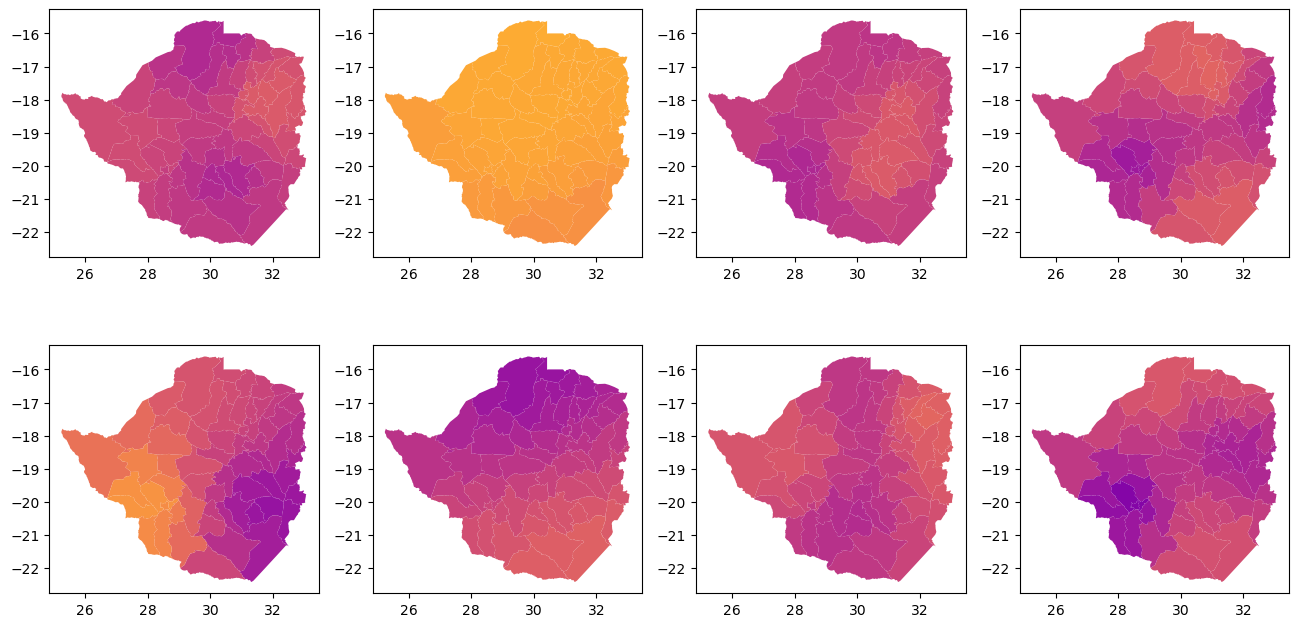

In [93]:
output_dir = '../../outputs/vmp2r78b'

trained_decoder_params = load_model_params(os.path.join(output_dir, "model"))["decoder"]
output_dim = trained_decoder_params["dec_out"]["bias"].shape[0]
hidden_dim = trained_decoder_params["dec_hidden_0"]["bias"].shape[0]
decoder = MLPDecoder(hidden_dim=hidden_dim, out_dim=output_dim, activations=dec_activation_fn)

rng_key, rng_key_ = jax.random.split(jax.random.PRNGKey(random.randint(0, 9999)))

cvae_predictive = Predictive(model_cvae, num_samples=100)
cvae_preds_map  = cvae_predictive(rng_key_, trained_decoder_params, latent_dim=latent_dim, n_obs = jnp.array(data.n_obs), 
                                  lengthscale = 0.1)

gp_predictive = Predictive(model_gp, num_samples=100)
gp_preds_map  = gp_predictive(rng_key_, x=x, n_obs = jnp.array(data.n_obs), lengthscale = 0.1)

cvae_preds_map_f = cvae_preds_map['f']
gp_preds_map_f   = gp_preds_map['re_std']

_max = np.max([cvae_preds_map_f, gp_preds_map_f])
_min = np.min([cvae_preds_map_f, gp_preds_map_f])

fig, axs = plt.subplots(2, 4, figsize=(16, 8))

for i in range(8):
    rows = int(i//4)
    cols = int(i%4)
    
    data['f' + str(i)] = cvae_preds_map_f[i, :]

    data.plot(column='f' + str(i),   ax=axs[rows][cols], cmap='plasma', vmin=_min, vmax =_max)

In [74]:
import os
cfg_path = os.path.join(output_dir, "files", "config.yaml")
with open(cfg_path, 'r') as file:
    cfg_data = yaml.safe_load(file)

conditional = cfg_data["conditional"]['value']
latent_dim = cfg_data["latent_dim"]['value']
normalize = cfg_data["normalize"]['value']
dec_activation_fn = cfg_data["dec_activation"]['value']["_target_"]
dec_activation_fn = getattr(nn, dec_activation_fn.split(".")[-1])

In [75]:
trained_decoder_params = load_model_params(os.path.join(output_dir, "model"))["decoder"]
output_dim = trained_decoder_params["dec_out"]["bias"].shape[0]
hidden_dim = trained_decoder_params["dec_hidden_0"]["bias"].shape[0]
decoder = MLPDecoder(hidden_dim=hidden_dim, out_dim=output_dim, activations=dec_activation_fn)

In [69]:
def model_cvae(trained_decoder_params, latent_dim, n_obs=None, lengthscale=None, y=None):
    
    # fixed effects
    #b0 = numpyro.sample('b0', npdist.Normal(0, 1))

    #if lengthscale == None:
    #    #lengthscale = numpyro.sample("lengthscale", npdist.Gamma(2,4)) 
    #    lengthscale = numpyro.sample("lengthscale", npdist.Uniform(0,1)) 
    
    lengthscale = numpyro.sample("lengthscale", npdist.Gamma(0.4, 2.0)) 

    c = jnp.array([lengthscale])

    kernel_var = numpyro.sample("variance", npdist.Gamma(1.5, 1.5)) 
#     kernel_var = 0.77
    
    z = numpyro.sample("z", npdist.Normal(jnp.zeros(latent_dim), jnp.ones(latent_dim)))
    z = jnp.concatenate([z, c]) 
    f = numpyro.deterministic('f', decoder.apply({'params': trained_decoder_params}, z))
     
    re = numpyro.deterministic('re', kernel_var * f)
    
    theta = numpyro.deterministic("theta", jax.nn.sigmoid(re))
    
    numpyro.sample("obs", npdist.BinomialLogits(total_count = n_obs, logits=re), obs=y)

## Inference PriorCVAE

In [77]:
# fname = 'zimbabwe_cvae_mcmc_Matern12.pkl'

rng_key, rng_key_predict = jax.random.split(jax.random.PRNGKey(random.randint(0, 999999)))

# inference
start = time.time()
kernel = NUTS(model_cvae)
mcmc_cvae = MCMC(kernel, num_warmup=num_warmup, num_samples=num_samples, num_chains=num_chains)
mcmc_cvae.run(rng_key, latent_dim=latent_dim, n_obs = jnp.array(data.n_obs), y = jnp.array(data.y))
t_elapsed = time.time() - start

  0%|          | 0/34000 [00:00<?, ?it/s]

  0%|          | 0/34000 [00:00<?, ?it/s]

In [26]:
mcmc_cvae.print_summary(exclude_deterministic=True)


                   mean       std    median      5.0%     95.0%     n_eff     r_hat
  lengthscale      0.45      0.10      0.44      0.34      0.52    821.97      1.00
     variance      1.27      0.34      1.21      0.79      1.73   2085.66      1.00
         z[0]      0.01      1.00      0.02     -1.69      1.61  50578.49      1.00
         z[1]     -0.65      0.34     -0.59     -1.16     -0.15   2705.39      1.00
         z[2]     -0.24      0.93     -0.25     -1.70      1.34  27544.57      1.00
         z[3]      0.01      0.15      0.01     -0.23      0.24  12908.56      1.00
         z[4]      0.02      1.00      0.02     -1.65      1.63  51279.61      1.00
         z[5]     -0.01      1.01     -0.01     -1.63      1.67  50391.54      1.00
         z[6]     -0.01      0.99     -0.01     -1.62      1.65  49186.22      1.00
         z[7]      0.00      1.00      0.01     -1.61      1.66  52119.78      1.00
         z[8]      0.74      0.89      0.76     -0.76      2.19  25727.89  

In [27]:
mcmc_cvae_samples = mcmc_cvae.get_samples()

In [29]:
print("\nMCMC elapsed time:", round(t_elapsed), "s")

ss = numpyro.diagnostics.summary(mcmc_cvae.get_samples(group_by_chain=True))
r = jnp.mean(ss['re']['n_eff'])
print("Average ESS for all REs : " + str(round(r)))


MCMC elapsed time: 13 s
Average ESS for all REs : 20675


<Figure size 640x480 with 0 Axes>

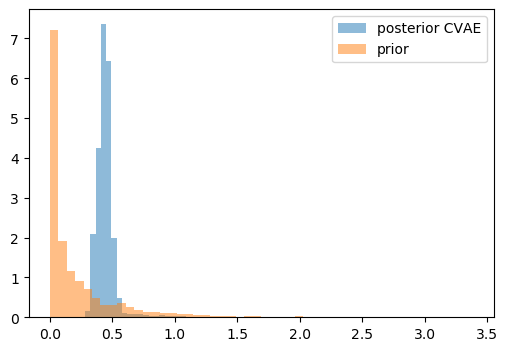

In [30]:
c_samps_cvae = mcmc_cvae_samples['lengthscale']

plt.clf()
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plt.hist(c_samps_cvae, density=True, label = 'posterior CVAE', bins=50, alpha=0.5)
# plt.hist(c_samps_gp, density=True, label = 'posterior GP', bins=50, alpha=0.5)
plt.hist(ls_prior_draws, density=True, label = 'prior', bins=50, alpha=0.5)
# plt.title('lengthscale, prior and posterior')
plt.legend()
#plt.xlim([0, 3])

# tikzplotlib.save(r"lengthscale.tex",
#                  figurewidth='\\figurewidth', figureheight='\\figureheight',
#                  figure=fig)

plt.show()

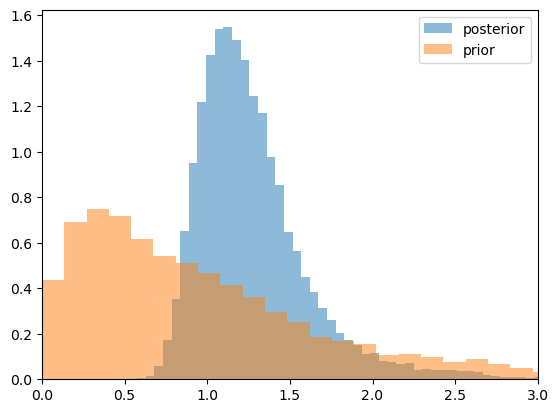

In [31]:
var_samps_cvae = mcmc_cvae_samples['variance']
plt.hist(var_samps_cvae, density=True, label = 'posterior', bins=50, alpha=0.5)
plt.hist(kernel_var_prior, density=True, label = 'prior', bins=50, alpha=0.5)
# plt.title('kernel_var, prior and posterior')
plt.legend()
plt.xlim(0,3)

# tikzplotlib.save(r"variance.tex",
#                 figurewidth='\\figurewidth', figureheight='\\figureheight',
#                 figure=fig)

plt.show()

(24.8460406, 33.4588074, -22.7626307, -15.268733300000001)

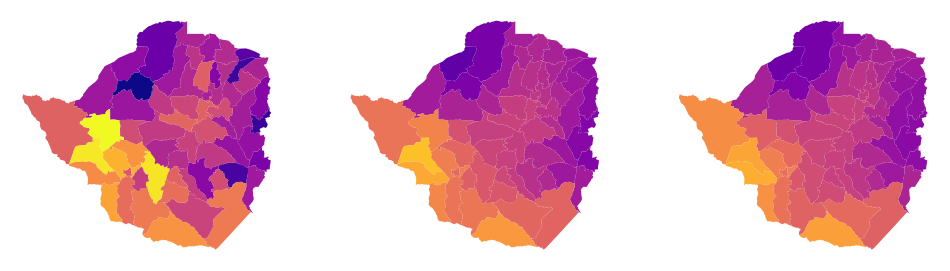

In [32]:
# posterior predictive
posterior_predictive_cvae = Predictive(model_cvae, mcmc_cvae_samples)(jax.random.PRNGKey(random.randint(0, 9999)), 
                                                                         latent_dim=latent_dim, 
                                                                         n_obs = jnp.array(data.n_obs))


theta_samps_cvae = posterior_predictive_cvae['theta']
theta_mean_cvae = theta_samps_cvae.mean(axis=0)
#bci_cvae_25 = jnp.quantile(theta_samps_cvae, 0.25, axis=0)
#bci_cvae_75 = jnp.quantile(theta_samps_cvae, 0.75, axis=0)

data['theta_cvae'] = theta_mean_cvae

theta_observed = jnp.array(data['estimate'])
theta_estimated_cvae = jnp.array(data['theta_cvae'])
theta_estimated_gp = jnp.array(data['theta_gp'])

_max = np.max([theta_observed, theta_estimated_gp, theta_estimated_cvae])
_min = np.min([theta_observed, theta_estimated_gp, theta_estimated_cvae])

fig, ax = plt.subplots(1, 3, figsize=(12,6))
data.plot(column="estimate",   ax=ax[0], cmap='plasma', vmin=_min, vmax =_max)
data.plot(column="theta_gp",   ax=ax[1], cmap='plasma', vmin=_min, vmax =_max)
data.plot(column="theta_cvae", ax=ax[2], cmap='plasma', vmin=_min, vmax =_max)

ax[0].axis("off")
ax[1].axis("off")
ax[2].axis("off")

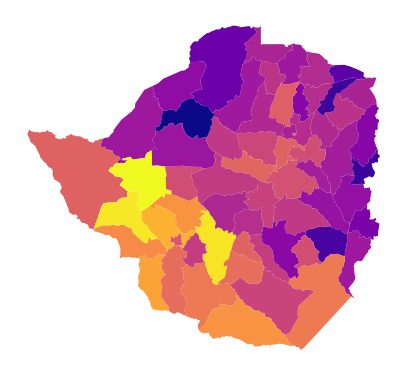

In [33]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
data.plot(column="estimate", ax=ax, cmap='plasma', vmin=_min, vmax =_max)
# data.plot(column="theta_gp",   ax=ax, cmap='plasma', vmin=_min, vmax =_max)
# data.plot(column="theta_cvae", ax=ax[2], cmap='plasma', vmin=_min, vmax =_max)

plt.axis("off")

plt.savefig("estimate.pdf", dpi=300)

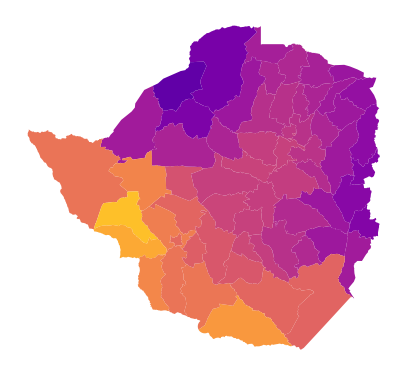

In [34]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# data.plot(column="estimate", ax=ax, cmap='plasma', vmin=_min, vmax =_max)
data.plot(column="theta_gp",   ax=ax, cmap='plasma', vmin=_min, vmax =_max)
# data.plot(column="theta_cvae", ax=ax[2], cmap='plasma', vmin=_min, vmax =_max)

plt.axis("off")

plt.savefig("gp_inference.pdf", dpi=300)

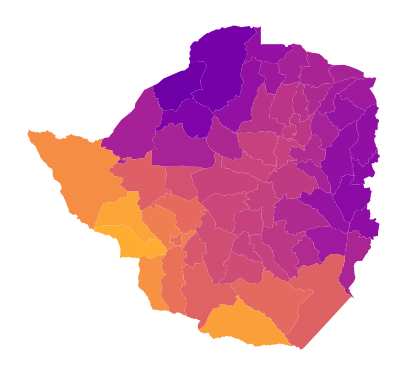

In [35]:
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
# data.plot(column="estimate", ax=ax, cmap='plasma', vmin=_min, vmax =_max)
# data.plot(column="theta_gp",   ax=ax, cmap='plasma', vmin=_min, vmax =_max)
data.plot(column="theta_cvae", ax=ax, cmap='plasma', vmin=_min, vmax =_max)

plt.axis("off")

plt.savefig("our_inference.pdf", dpi=300)

In [36]:
theta_estimated_gp.shape, theta_estimated_cvae.shape

((63,), (63,))

FileNotFoundError: [Errno 2] No such file or directory: '../../../../../papers/priorcvae/figures/zimbabwe/theta_comparison_gp_cvae.tex'

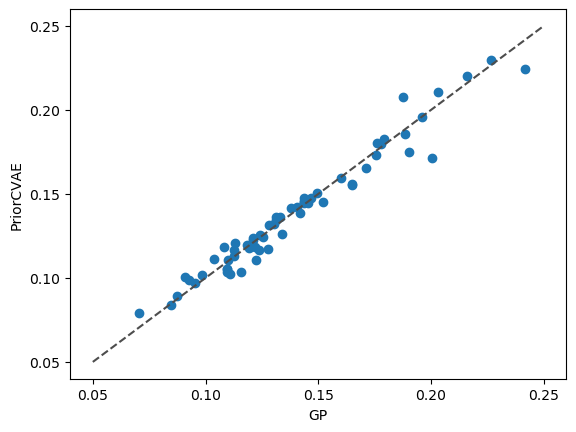

In [37]:
plt.clf()

plt.plot(theta_estimated_gp.reshape((-1, 1)), theta_estimated_cvae.reshape((-1, 1)), "o")
plt.plot([0.05, 0.25], [0.05, 0.25], ls="--", c=".3")
plt.xlabel('GP')
plt.ylabel('PriorCVAE')
plt.yticks([0.05, 0.1, 0.15, 0.2, 0.25])
plt.xticks([0.05, 0.1, 0.15, 0.2, 0.25])

tikzplotlib.save(r"../../../../../papers/priorcvae/figures/zimbabwe/theta_comparison_gp_cvae.tex",
                figurewidth='\\figurewidth', figureheight='\\figureheight')

Text(0, 0.5, 'cvae')

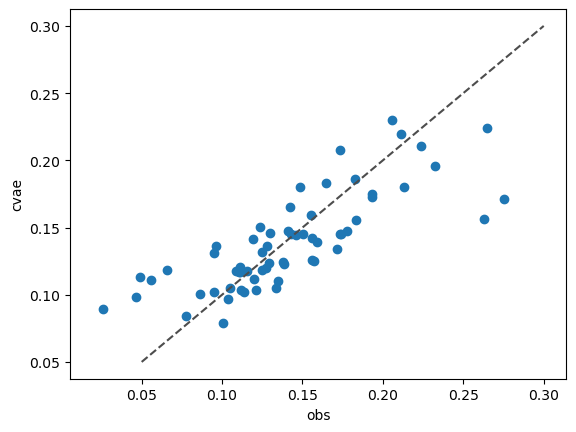

In [38]:
plt.scatter(theta_observed, theta_estimated_cvae)
plt.plot([0.05, 0.3], [0.05, 0.3], ls="--", c=".3")
plt.xlabel('obs')
plt.ylabel('cvae')

Text(0, 0.5, 'gp')

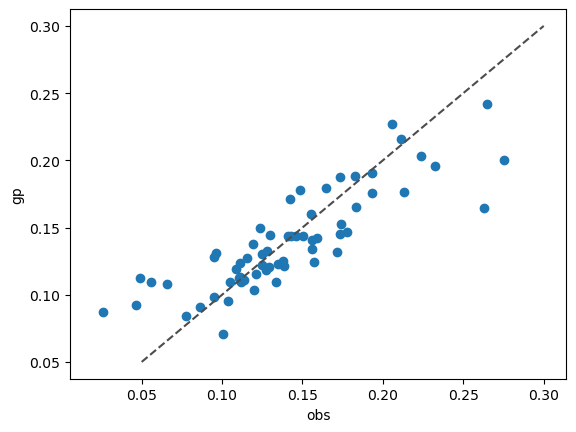

In [39]:
plt.scatter(theta_observed, theta_estimated_gp)
plt.plot([0.05, 0.3], [0.05, 0.3], ls="--", c=".3")
plt.xlabel('obs')
plt.ylabel('gp')

## Plot PriorCVAE priors

In [40]:
rng_key, rng_key_ = jax.random.split(jax.random.PRNGKey(random.randint(0, 9999)))

cvae_predictive = Predictive(model_cvae, num_samples=100)
cvae_preds_map  = cvae_predictive(rng_key_, latent_dim=latent_dim, n_obs = jnp.array(data.n_obs), 
                                  lengthscale = 0.1)

gp_predictive = Predictive(model_gp, num_samples=100)
gp_preds_map  = gp_predictive(rng_key_, x=x, n_obs = jnp.array(data.n_obs), lengthscale = 0.1)

cvae_preds_map_f = cvae_preds_map['f']
gp_preds_map_f   = gp_preds_map['re_std']

_max = np.max([cvae_preds_map_f, gp_preds_map_f])
_min = np.min([cvae_preds_map_f, gp_preds_map_f])

fig, axs = plt.subplots(2, 4, figsize=(16, 8))

for i in range(8):
    rows = int(i//4)
    cols = int(i%4)
    
    data['f' + str(i)] = cvae_preds_map_f[i, :]

    data.plot(column='f' + str(i),   ax=axs[rows][cols], cmap='plasma', vmin=_min, vmax =_max)


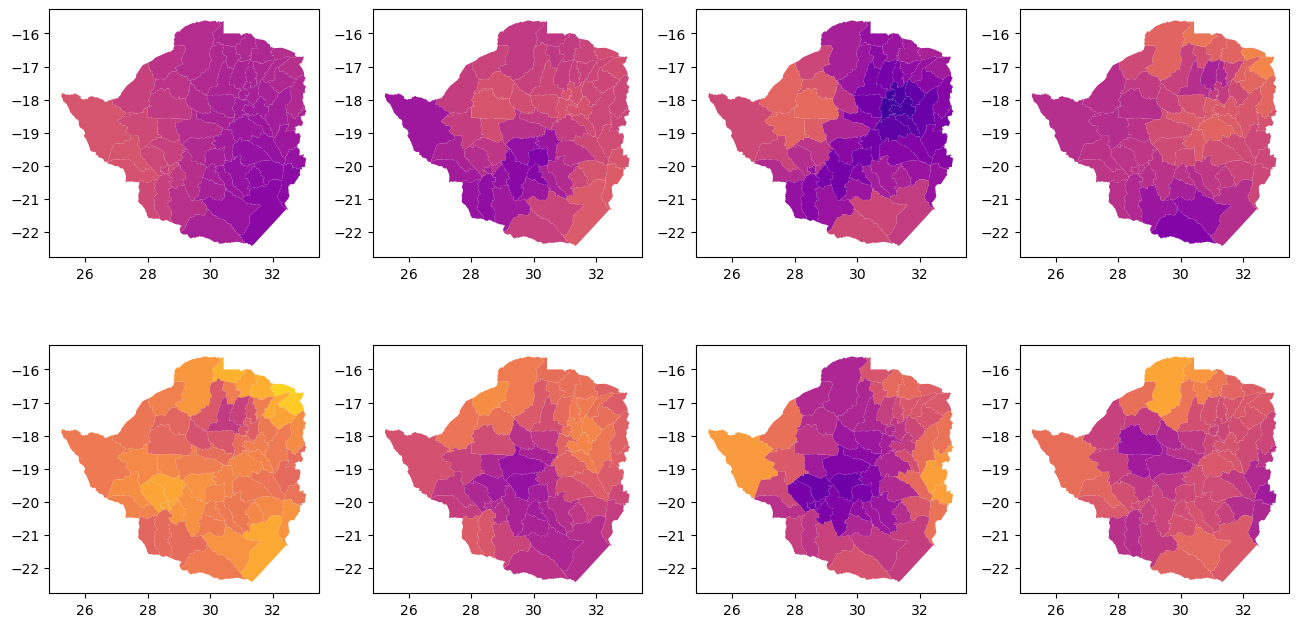

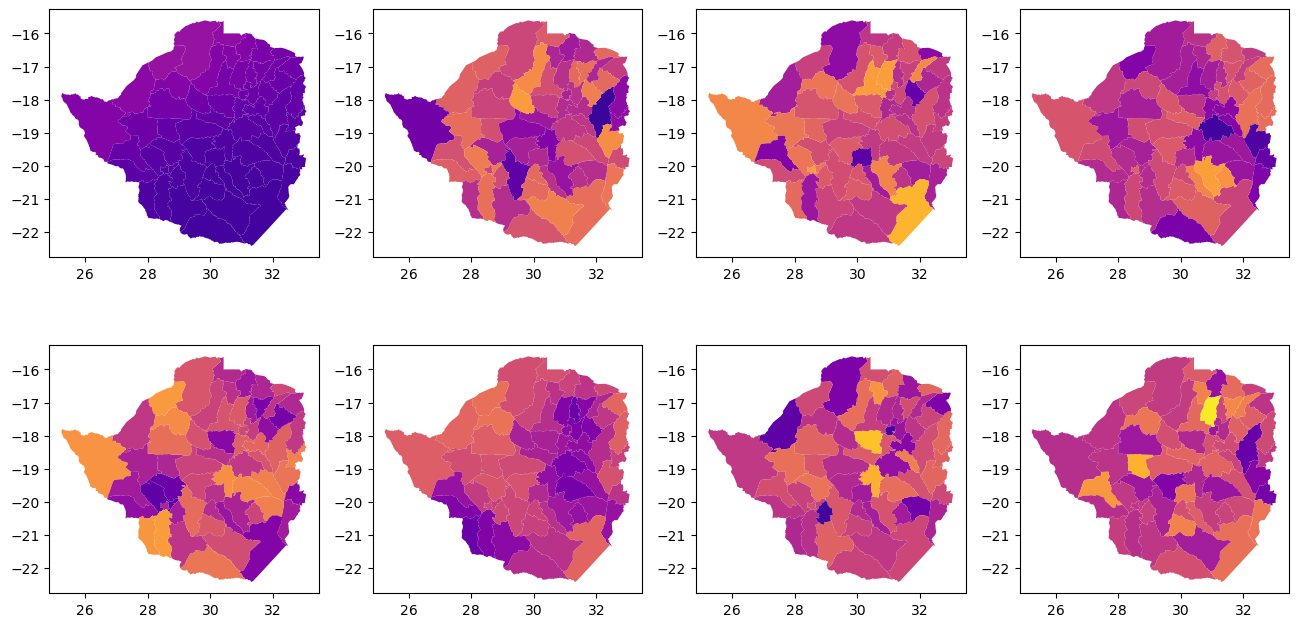

In [44]:
fig, axs = plt.subplots(2, 4, figsize=(16, 8))

for i in range(8):
    rows = int(i//4)
    cols = int(i%4)
    
    data['gp' + str(i)] = gp_preds_map_f[i, :]

    data.plot(column='gp' + str(i),   ax=axs[rows][cols], cmap='plasma', vmin=_min, vmax =_max)

## Plot ls

(0, 1.0)

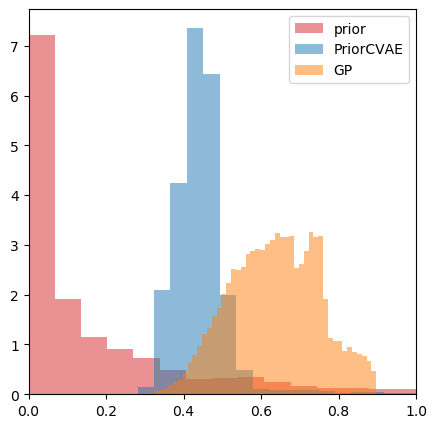

In [50]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))

plt.hist(ls_prior_draws, density=True, bins=50, alpha=0.5, color="tab:red", label='prior')
plt.hist(c_samps_cvae, density=True, bins=50, alpha=0.5, color="tab:blue", label='PriorCVAE')
plt.hist(c_samps_gp, density=True, bins=50, alpha=0.5, color="tab:orange", label='GP')

plt.legend()
plt.xlim(0, 1.)

#tikzplotlib.save(r"../../../../../papers/priorcvae/figures/zimbabwe/lengthscale.tex",
#                figurewidth='\\figurewidth', figureheight='\\figureheight')


(0, 3)

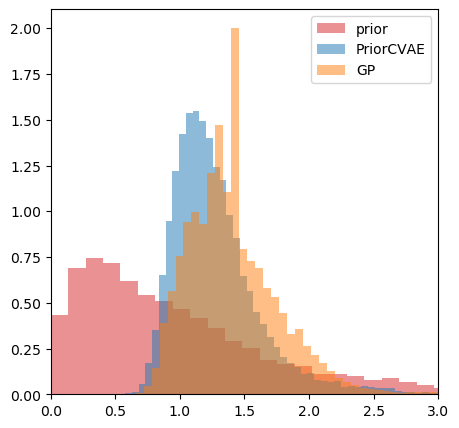

In [52]:
fig, axs = plt.subplots(1, 1, figsize=(5, 5))

plt.hist(kernel_var_prior, density=True, bins=50, alpha=0.5, color="tab:red", label='prior')
plt.hist(mcmc_cvae_samples['variance'], density=True, bins=50, alpha=0.5, color="tab:blue", label='PriorCVAE')
plt.hist(var_samps_gp, density=True, bins=50, alpha=0.5, color="tab:orange", label='GP')

plt.legend()
plt.xlim(0, 3)

#tikzplotlib.save(r"../../../../../papers/priorcvae/figures/zimbabwe/variance.tex",
#                figurewidth='\\figurewidth', figureheight='\\figureheight')


In [53]:
# plt.hist(ls_prior_draws, density=True, label = 'Prior', bins=50, alpha=0.5, color="tab:red")
# plt.hist(c_samps_cvae, density=True, label = 'PriorCVAE', bins=50, alpha=0.5, color="tab:blue")
# plt.hist(c_samps_gp, density=True, label = 'GP', bins=50, alpha=0.5, color="tab:orange")

# plt.legend()
# # plt.xlim(0, 1.)

# # tikzplotlib.save(r"variance.tex",
# #                 figurewidth='\\figurewidth', figureheight='\\figureheight',
# #                 figure=fig)


In [54]:
import scipy

In [55]:
x_min = min((jnp.min(c_samps_gp), jnp.min(c_samps_cvae)))
x_max = max((jnp.max(c_samps_gp), jnp.max(c_samps_cvae)))

In [56]:
x_min, x_max

(Array(0.06891103, dtype=float64), Array(2.19217097, dtype=float64))

(0, 1)

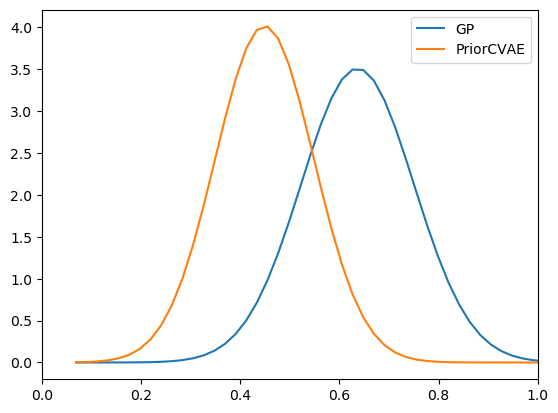

In [57]:
x_tmp = jnp.linspace(x_min, x_max, 100)

gp_mean = jnp.mean(c_samps_gp)
gp_std = jnp.std(c_samps_gp)

cvae_mean = jnp.mean(c_samps_cvae)
cvae_std = jnp.std(c_samps_cvae)

plt.plot(x_tmp, scipy.stats.norm.pdf(x_tmp, gp_mean, gp_std), label='GP')
plt.plot(x_tmp, scipy.stats.norm.pdf(x_tmp, cvae_mean, cvae_std), label='PriorCVAE')
# plt.plot(x_tmp, scipy.stats.norm.pdf(x_tmp, gp_mean, gp_std), label='GP', alpha=0.5)

# plt.hist(c_samps_cvae, density=True, label = 'CVAE', bins=50, alpha=0.5)
# plt.hist(ls_prior_draws, density=True, label = 'prior', bins=50, alpha=0.5)
# plt.hist(c_samps_gp, density=True)

plt.legend()
plt.xlim(0, 1)

## Comparison against INLA

In [67]:
inla_lengthscale_path = r"inla_results/lengthscale.csv"
inla_variance_path = r"inla_results/variance.csv"

In [35]:
arr = np.loadtxt(inla_lengthscale_path, delimiter=",", dtype=str, skiprows=1)

x = np.array(arr[:, 1], dtype=np.float64)
y = np.array(arr[:, 2], dtype=np.float64)


In [68]:
arr = np.loadtxt(inla_variance_path, delimiter=",", dtype=str, skiprows=1)

x_variance = np.array(arr[:, 1], dtype=np.float64)
y_variance = np.array(arr[:, 2], dtype=np.float64)


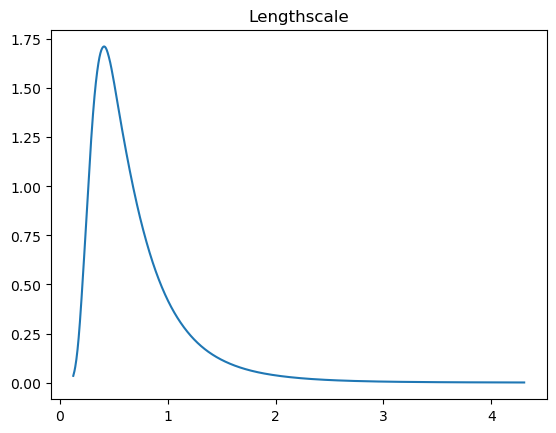

In [69]:
plt.plot(x, y)
plt.title("Lengthscale")
plt.show()

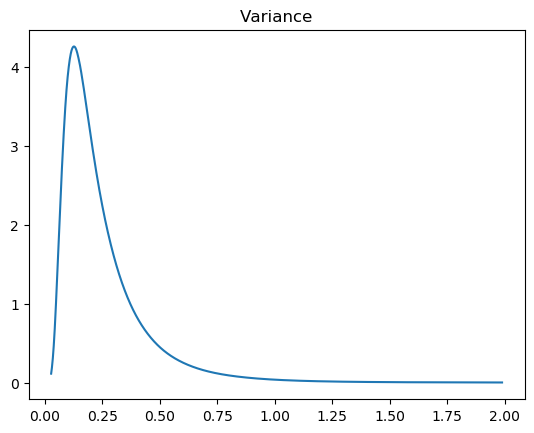

In [70]:
plt.plot(x_variance, y_variance)
plt.title("Variance")
plt.show()

<Figure size 640x480 with 0 Axes>

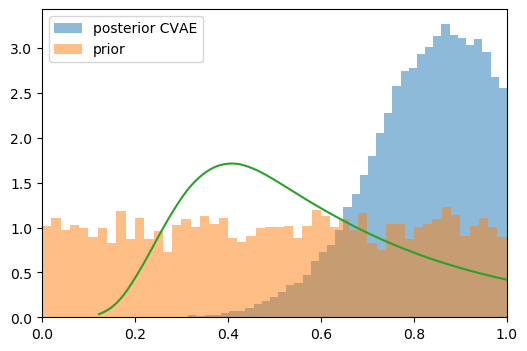

In [38]:
c_samps_cvae = mcmc_cvae_samples['lengthscale']

plt.clf()
fig, ax = plt.subplots(1, 1, figsize=(6, 4))
plt.hist(c_samps_cvae, density=True, label = 'posterior CVAE', bins=50, alpha=0.5)
# plt.hist(c_samps_gp, density=True, label = 'posterior GP', bins=50, alpha=0.5)
plt.hist(ls_prior_draws, density=True, label = 'prior', bins=50, alpha=0.5)
plt.plot(x, y)
# plt.title('lengthscale, prior and posterior')
plt.legend()
plt.xlim([0, 1])

# tikzplotlib.save(r"lengthscale.tex",
#                  figurewidth='\\figurewidth', figureheight='\\figureheight',
#                  figure=fig)

plt.show()

In [41]:
import scipy

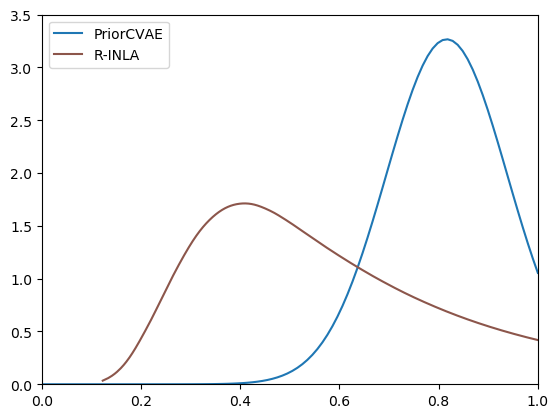

In [74]:
x_tmp = jnp.linspace(0, 1, 100)

cvae_mean = jnp.mean(c_samps_cvae)
cvae_std = jnp.std(c_samps_cvae)

prior_mean = jnp.mean(ls_prior_draws)
prior_std = jnp.std(ls_prior_draws)

plt.plot(x_tmp, scipy.stats.norm.pdf(x_tmp, cvae_mean, cvae_std), color="tab:blue", label="PriorCVAE")
# plt.hlines(1, 0, 1, color="tab:red", linestyle="dashed", label="Prior")
plt.plot(x, y, color="tab:brown", label="R-INLA")

plt.legend(loc="upper left")
plt.xlim(0, 1)
plt.ylim([0, 3.5])

tikzplotlib.save(r"../../../../../papers/priorcvae/figures/zimbabwe/lengthscale_inla.tex",
                figurewidth='\\figurewidth', figureheight='\\figureheight')

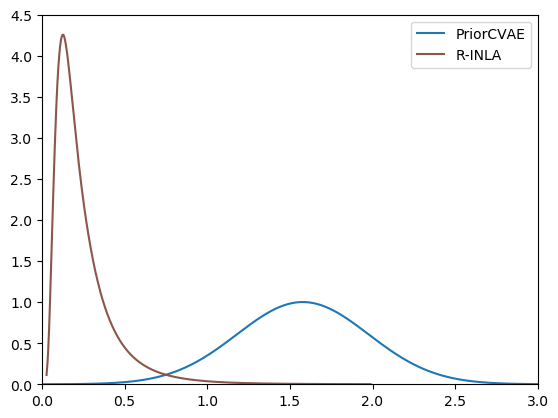

In [79]:
x_tmp = jnp.linspace(0, 3, 1000)

cvae_mean = jnp.mean(mcmc_cvae_samples['variance'])
cvae_std = jnp.std(mcmc_cvae_samples['variance'])

# prior_mean = jnp.mean()
# prior_std = jnp.std(ls_prior_draws)

plt.plot(x_tmp, scipy.stats.norm.pdf(x_tmp, cvae_mean, cvae_std), color="tab:blue", label="PriorCVAE")
# plt.hlines(1, 0, 1, color="tab:red", linestyle="dashed", label="Prior")
plt.plot(x_variance, y_variance, color="tab:brown", label="R-INLA")

plt.legend(loc="upper right")
plt.xlim(0, 3)
plt.ylim([0, 4.5])

tikzplotlib.save(r"../../../../../papers/priorcvae/figures/zimbabwe/variance_inla.tex",
                figurewidth='\\figurewidth', figureheight='\\figureheight')